In [0]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
!pip install mpld3
import mpld3
mpld3.enable_notebook()

     |████████████████████████████████| 798kB 4.6MB/s 
  Created wheel for mpld3: filename=mpld3-0.3-cp36-none-any.whl size=116679 sha256=2b9857debe9ad6817e8ab10ee94d380b76d81e02bef0570aa8cc9a0282329f7f
  Stored in directory: /root/.cache/pip/wheels/c0/47/fb/8a64f89aecfe0059830479308ad42d62e898a3e3cefdf6ba28
Successfully built mpld3


In [0]:
def plotseird(t, S, E,Ip, Ic, Ih, Is, Iicu, R, D, R0=None):
    f, ax = plt.subplots(1, 1, figsize=(10, 4))
    ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
    ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
    ax.plot(t, Ip, 'orange', alpha=0.7, linewidth=2, label='Pre-clinical')
    ax.plot(t, Ic, 'r', alpha=0.7, linewidth=2, label='Clinical')
    ax.plot(t, Ih, 'indigo', alpha=0.7, linewidth=2, label='Isolated')
    ax.plot(t, Is, 'violet', alpha=0.7, linewidth=2, label='Sub-clinical')
    ax.plot(t, Iicu, 'pink', alpha=0.7, linewidth=2, label='ICU')
    ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
    ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    ax.plot(t, S + E + Ip + Ic + Ih + Is + Iicu + R + D, 'c--', alpha=0.7, linewidth=2, label='Total')

    ax.set_xlabel('Time (days)')

    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend(borderpad=2.0)
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)        

    if R0 is not None:
        # sp1
        f = plt.figure(figsize=(12, 4))
        ax1 = f.add_subplot(121)
        ax1.plot(t, R0, 'b--', alpha=0.7, linewidth=2, label='R_0')

        ax1.set_xlabel('Time (days)')
        ax1.title.set_text('R_0 over time')
        # ax.set_ylabel('Number (1000s)')
        # ax.set_ylim(0,1.2)
        ax1.yaxis.set_tick_params(length=0)
        ax1.xaxis.set_tick_params(length=0)
        ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
        legend = ax1.legend()
        legend.get_frame().set_alpha(0.5)
        for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)

        plt.show()

In [0]:
def deriv(y, t, N, beta, SD, cm, em, eta_ip, eta_ih, eta_ic, eta_is, epsilon, o1, o2, alpha_Ip, sigma_Ic, p1, p2, phi_Ic, delta_I, gamma_I, q1, q2, q3, nu_h, gamma_Ih, alpha_Is, r1, r2, t1, t2, gamma_Is, delta_ICU, gamma_ICU, s1, s2):
    S, E,Ip, Ic, Ih, Is, Iicu, R, D = y
    force_of_infection = beta * SD * (1 - (em * cm)) * ((eta_ic * Ic) + (eta_is * Is) + (eta_ip * Ip) + (eta_ih * Ih)) / N
    dSdt = -force_of_infection * S
    dEdt = force_of_infection * S - (epsilon * o1 + epsilon * o2) * E
    dIpdt = epsilon * o1 * E - ((p1 * alpha_Ip + p2 * sigma_Ic) * Ip)
    dIcdt = (p2 * sigma_Ic * Ip) - ((q1 * phi_Ic + q2 * delta_I + q3 * gamma_I) * Ic)
    dIhdt = (p1 * alpha_Ip * Ip + q1 * phi_Ic * Ic + t1 * alpha_Is * Is) - ((r1 * nu_h + r2 * gamma_Ih) * Ih)
    dIsdt = (epsilon * o2 * E) - (t1 * alpha_Is + t2 * gamma_Is) * Is
    dIicudt = (r1 * nu_h * Ih) - (s1 * delta_ICU + s2 * gamma_ICU) * Iicu
    dRdt = q3 * gamma_I * Ic + r2 * gamma_Ih * Ih + t2 * gamma_Is * Is + s2 * gamma_ICU * Iicu
    dDdt = q2 * delta_I * Ic + s1 * delta_ICU * Iicu
    return dSdt, dEdt, dIpdt, dIcdt, dIhdt, dIsdt, dIicudt, dRdt, dDdt  

In [0]:
N = 3_200_000
Face_Mask_Efficacy = 0.0
Face_Mask_Coverage = 0.0
Social_Distancing = 1


days_from_E_to_preclinical = 4.0
epsilon = 1/days_from_E_to_preclinical
proportion_of_exposed_to_preclinical = 0.55
proportion_of_exposed_to_subclinical = 1 - (proportion_of_exposed_to_subclinical)
o1 = proportion_of_exposed_to_preclinical
o2 = proportion_of_exposed_to_subclinical

days_from_preclinical_to_clinical = 1.5
# days_from_preclinical_to_subclinical = 5.1
days_from_preclinical_to_isolated = 1.5
proportion_from_preclinical_to_isolated = 0.05
proportion_from_preclinical_to_clinical = 1 - (proportion_from_preclinical_to_isolated)
# proportion_from_preclinical_to_clinical = 0.4
# proportion_from_preclinical_to_subclinical = (1 - (proportion_from_preclinical_to_clinical + proportion_from_preclinical_to_isolated))

# sigma_Is = 1/days_from_preclinical_to_subclinical
sigma_Ic = 1/days_from_preclinical_to_clinical
alpha_Ip = 1/days_from_preclinical_to_isolated
p1 = proportion_from_preclinical_to_isolated
p2 = proportion_from_preclinical_to_clinical
# p3 = proportion_from_preclinical_to_subclinical


days_from_clinical_to_recovery = 8.0
# Intervention - 2.0
delay_in_days_to_isolate_the_infected = 7.0
days_from_clinical_to_death = 8.0
phi_Ic = 1/delay_in_days_to_isolate_the_infected
gamma_I = 1/days_from_clinical_to_recovery
delta_I = 1/days_from_clinical_to_death
# Intervention - 0.33 --> 0.67
proportion_from_clinical_to_isolated = 0.33
proportion_from_clinical_to_death = 0.001
proportion_from_clinical_to_recovery = (1 - (proportion_from_clinical_to_isolated + proportion_from_clinical_to_death))
q1 = proportion_from_clinical_to_isolated
q2 = proportion_from_clinical_to_death
q3 = proportion_from_clinical_to_recovery

days_from_isolation_to_ICU_admission = 12.0
days_from_isolation_to_recovery = 14.0
nu_h = 1/days_from_isolation_to_ICU_admission
gamma_Ih = 1/days_from_isolation_to_recovery
proportion_from_isolated_to_ICU = 0.06
proportion_from_isolated_to_recovery = 1 - proportion_from_isolated_to_ICU
r1 = proportion_from_isolated_to_ICU
r2 = proportion_from_isolated_to_recovery 

days_from_ICU_to_Death = 4.0
days_from_ICU_to_recovery =14.0 
gamma_ICU = 1/days_from_ICU_to_recovery
delta_ICU = 1/days_from_ICU_to_Death
proportion_from_ICU_to_death = 0.1
proportion_from_ICU_recovery = 1 - proportion_from_ICU_to_death
s1 = proportion_from_ICU_to_death
s2 = proportion_from_ICU_recovery

days_from_subclinical_to_Isolated = 5.1
days_from__subclinical_to_recovery = 14.0
gamma_Is = 1/days_from__subclinical_to_recovery
alpha_Is = 1/days_from_subclinical_to_Isolated
proportion_from_subclinical_to_Isolated = 0.1
proportion_from_subclinical_to_recovery = 1 - proportion_from_subclinical_to_Isolated
t1 = proportion_from_subclinical_to_Isolated
t2 = proportion_from_subclinical_to_recovery

Infectiuos_period = days_from_clinical_to_recovery
gamma_for_beta = 1.0 / Infectiuos_period

R_0 = 2.6
beta = R_0 * gamma_for_beta  # R_0 = beta / gamma, so beta = R_0 * gamma
relative_infectiousness_of_preclinical_compared_to_non_isolated_infectious=1
relative_infectiousness_of_isolated_compared_to_non_isolated_infectious=0.0
relative_infectiousness_of_clinical_compared_to_non_isolated_infectious=1
relative_infectiousness_of_subclinical_compared_to_non_isolated_infectious=0.5
eta_ih = relative_infectiousness_of_isolated_compared_to_non_isolated_infectious
eta_ip = relative_infectiousness_of_preclinical_compared_to_non_isolated_infectious
eta_ic = relative_infectiousness_of_clinical_compared_to_non_isolated_infectious
eta_is = relative_infectiousness_of_subclinical_compared_to_non_isolated_infectious
SD = Social_Distancing
em = Face_Mask_Efficacy
cm = Face_Mask_Coverage

E0 = 0.05 * N
# initial conditions: E0 = 10% of N
S0, E0,Ip0, Ic0, Ih0, Is0, Iicu0,R0, D0 = N - E0 - Ip0 - Ic0 - Ih0 - Is0 - Iicu0 - R0 - D0, E0, 1000, 1000, 582, 425, 5, 152, 5

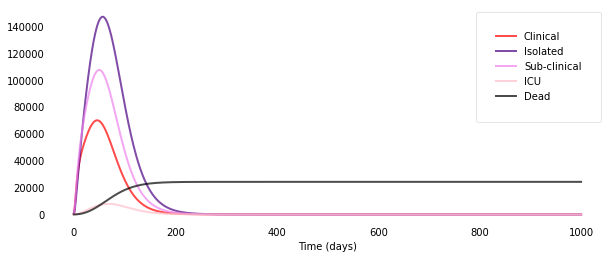

In [0]:
t = np.linspace(0, 999, 1000)  # Grid of time points (in days)
y0 = S0, E0,Ip0, Ic0, Ih0, Is0, Iicu0,R0, D0  # Initial conditions vector

ret = odeint(deriv, y0, t, args=(N, beta, SD, cm, em, eta_ip, eta_ih, eta_ic, eta_is, epsilon, o1, o2, alpha_Ip, sigma_Ic, p1, p2, phi_Ic, delta_I, gamma_I, q1, q2, q3, nu_h, gamma_Ih, alpha_Is, r1, r2, t1, t2, gamma_Is, delta_ICU, gamma_ICU, s1, s2))
S, E,Ip, Ic, Ih, Is, Iicu, R, D = ret.T

plotseird(t, S, E,Ip, Ic, Ih, Is, Iicu, R, D)

In [0]:
def deriv_ro(y, t, N, beta, SD, cm, em, eta_ip, eta_ih, eta_ic, eta_is, epsilon, o1, o2, alpha_Ip, sigma_Ic, p1, p2, phi_Ic, delta_I, gamma_I, q1, q2, q3, nu_h, gamma_Ih, alpha_Is, r1, r2, t1, t2, gamma_Is, delta_ICU, gamma_ICU, s1, s2):
    S, E,Ip, Ic, Ih, Is, Iicu, R, D = y
    force_of_infection = beta(t) * SD * (1 - (em * cm)) * ((eta_ic * Ic) + (eta_is * Is) + (eta_ip * Ip) + (eta_ih * Ih)) / N
    dSdt = -force_of_infection * S
    dEdt = force_of_infection * S - (epsilon * o1 + epsilon * o2) * E
    dIpdt = epsilon * o1 * E - ((p1 * alpha_Ip + p2 * sigma_Ic) * Ip)
    dIcdt = (p2 * sigma_Ic * Ip) - ((q1 * phi_Ic + q2 * delta_I + q3 * gamma_I) * Ic)
    dIhdt = (p1 * alpha_Ip * Ip + q1 * phi_Ic * Ic + t1 * alpha_Is * Is) - ((r1 * nu_h + r2 * gamma_Ih) * Ih)
    dIsdt = (epsilon * o2 * E) - (t1 * alpha_Is + t2 * gamma_Is) * Is
    dIicudt = (r1 * nu_h * Ih) - (s1 * delta_ICU + s2 * gamma_ICU) * Iicu
    dRdt = q3 * gamma_I * Ic + r2 * gamma_Ih * Ih + t2 * gamma_Is * Is + s2 * gamma_ICU * Iicu
    dDdt = q2 * delta_I * Ic + s1 * delta_ICU * Iicu
    return dSdt, dEdt, dIpdt, dIcdt, dIhdt, dIsdt, dIicudt, dRdt, dDdt  

In [0]:
R_0_start, k, x0, R_0_end = 3.85, 0.5, 50, 0.5


def logistic_R_0(t):
    return (R_0_start - R_0_end) / (1 + np.exp(-k * (-t + x0))) + R_0_end


def beta(t):
    return logistic_R_0(t) * gamma_for_beta

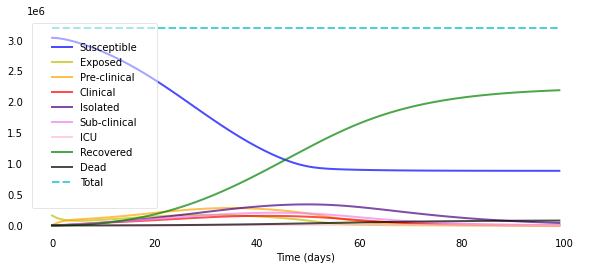

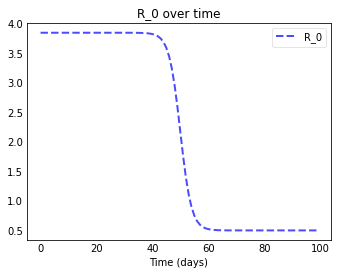

In [0]:
ret = odeint(deriv_ro, y0, t, args=(N, beta, SD, cm, em, eta_ip, eta_ih, eta_ic, eta_is, epsilon, o1, o2, alpha_Ip, sigma_Ic, p1, p2, phi_Ic, delta_I, gamma_I, q1, q2, q3, nu_h, gamma_Ih, alpha_Is, r1, r2, t1, t2, gamma_Is, delta_ICU, gamma_ICU, s1, s2))
S, E,Ip, Ic, Ih, Is, Iicu, R, D = ret.T
R0_over_time = [logistic_R_0(i) for i in range(len(t))]  # to plot R_0 over time: get function values
plotseird(t, S, E,Ip, Ic, Ih, Is, Iicu, R, D, R0=R0_over_time)